In [ ]:
%pip install transformers torch torchaudio librosa scipy scikit-learn matplotlib pandas numpy  --quiet


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import math
import numpy as np
import pandas as pd
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertModel, BertTokenizerFast
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = os.getcwd()

MELD_CSV_ROOT = os.path.join(BASE_DIR, "MELD.RAW")
MELD_VIDEO_ROOT = os.path.join(BASE_DIR, "MELD.Raw")
CSV_TRAIN = os.path.join(MELD_CSV_ROOT, "train_sent_emo.csv")
CSV_DEV   = os.path.join(MELD_CSV_ROOT, "dev_sent_emo.csv")
CSV_TEST  = os.path.join(MELD_CSV_ROOT, "test_sent_emo.csv")
VIDEO_TRAIN = os.path.join(MELD_VIDEO_ROOT, "train")
VIDEO_TRAIN = os.path.join(MELD_VIDEO_ROOT, "train_splits")
VIDEO_DEV   = os.path.join(MELD_VIDEO_ROOT, "dev_splits_complete")
VIDEO_TEST  = os.path.join(MELD_VIDEO_ROOT, "output_repeated_splits_test")

print("CSV_TRAIN  :", CSV_TRAIN)
print("CSV_DEV    :", CSV_DEV)
print("CSV_TEST   :", CSV_TEST)
print("VIDEO_TRAIN:", VIDEO_TRAIN)
print("VIDEO_DEV  :", VIDEO_DEV)
print("VIDEO_TEST :", VIDEO_TEST)

# -------------------- Device --------------------
if torch.cuda.is_available():
    DEVICE = torch.device("cuda") #dans le cas ou si y'a une nvidia
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  #dans le cas ou c'est un mac 
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


CSV_TRAIN  : /Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/MELD.RAW/train_sent_emo.csv
CSV_DEV    : /Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/MELD.RAW/dev_sent_emo.csv
CSV_TEST   : /Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/MELD.RAW/test_sent_emo.csv
VIDEO_TRAIN: /Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/MELD.Raw/train_splits
VIDEO_DEV  : /Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/MELD.Raw/dev_splits_complete
VIDEO_TEST : /Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/MELD.Raw/output_repeated_splits_test
Device: mps


In [ ]:
SENTIMENT_MAP = {
    "negative": -1.0,
    "neutral": 0.0,
    "positive": 1.0,
}

class MELDVideoDataset(Dataset):
    def __init__(self, csv_path: str, video_dir: str):
        self.df = pd.read_csv(csv_path)
        self.video_dir = video_dir
        self.samples = []

        for _, row in self.df.iterrows():
            sent_str = str(row["Sentiment"]).lower()
            if sent_str not in SENTIMENT_MAP:
                continue

            dialog_id = int(row["Dialogue_ID"])
            utt_id    = int(row["Utterance_ID"])

            video_name = f"dia{dialog_id}_utt{utt_id}.mp4"
            video_path = os.path.join(self.video_dir, video_name)

            self.samples.append({
                "utterance": str(row["Utterance"]),
                "emotion":   str(row["Emotion"]),
                "sentiment": SENTIMENT_MAP[sent_str],
                "audio_path": video_path,  # MP4 mais on lit l'audio
            })

        print(f"{os.path.basename(csv_path)} -> {len(self.samples)} exemples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def meld_collate(batch):
    utterances = [b["utterance"] for b in batch]
    emotions   = [b["emotion"] for b in batch]
    audio_paths = [b["audio_path"] for b in batch]
    labels     = torch.tensor([b["sentiment"] for b in batch], dtype=torch.float32)
    return utterances, emotions, audio_paths, labels


In [ ]:
train_ds = MELDVideoDataset(CSV_TRAIN, VIDEO_TRAIN) #on charge les données et on les mets en dataset pytorch car il peut prendre pleins de type
dev_ds   = MELDVideoDataset(CSV_DEV,   VIDEO_DEV)
test_ds  = MELDVideoDataset(CSV_TEST,  VIDEO_TEST)
print("Train size:", len(train_ds), "Dev size:", len(dev_ds), "Test size:", len(test_ds))


train_sent_emo.csv -> 9989 exemples
dev_sent_emo.csv -> 1109 exemples
test_sent_emo.csv -> 2610 exemples
Train size: 9989 Dev size: 1109 Test size: 2610


In [ ]:
#class qui va nous permettre de encoder avec Bert et appliquer un transformers encoder
class TextEncoder(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", T=8):
        super().__init__()
        self.T = T
        self.bert = BertModel.from_pretrained(bert_model_name) #on prend le bert de base d'apres la doc 12 couches 768 dimensions
        self.hidden_size = self.bert.config.hidden_size

        #notre transformer qui va melanger le mod_token avec les token du texte pour que la fusion soit meilleur! 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_size,
            nhead=8,
            dim_feedforward=2048,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        #notre fameux mod_token 
        self.mod_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size)) #beaucoup mieux pour un MLD d'avoir un MOD qu'un CLS

    def forward(self, input_ids, attention_mask):
        #on passe dans bert
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state  # retourne embedding par token Batch / longueur / Hidden
        B, L, H = x.shape
        mod_tok = self.mod_token.expand(B, 1, H)
        x = torch.cat([mod_tok, x], dim=1)   #[B,1+L,H] #on represente toute la phrase dans un vecteur et on rajoute un MOD (token) qui resume notre texte en premiere position
        x = self.transformer(x)              #[B,1+L,H]

        #là etape importante on doit forcement avoir le meme nombre d'embedding donc on comble de 0 (ultra important pour la fusion d'avoir les echantillons de meme taille)
        if x.size(1) < self.T:
            pad = torch.zeros(B, self.T - x.size(1), H, device=x.device)
            x = torch.cat([x, pad], dim=1)

        return x[:, :self.T, :]             # [B,T,H]


In [ ]:
#fonction qui permet d'extraire les audios des mp4
#de l'audio on va extraire le pitch (frequence de la voix), loudness_db (insensité perçu), jitter (instabilité de la frequence), shimmer (instabilité de l'amplitude)
def extract_audio_features(path: str, sr: int = 16000) -> Tuple[float, float, float, float]:
    #si fichier n'existe pas on met des valeurs par defaut
    if not path or not os.path.isfile(path):
        return 180.0, -20.0, 1.0, 1.0

    try:
        y, sr = librosa.load(path, sr=sr)
        if len(y) == 0:
            return 180.0, -20.0, 1.0, 1.0

        rms = librosa.feature.rms(y=y)[0]
        loudness_db = float(np.mean(librosa.amplitude_to_db(rms + 1e-6)))

        f0 = librosa.yin(y, fmin=50, fmax=400, sr=sr)
        f0 = f0[np.isfinite(f0)]
        if len(f0) == 0:
            pitch = 180.0
            jitter = 1.0
        else:
            pitch = float(np.median(f0))
            jitter = float(100 * np.std(f0) / (np.mean(f0) + 1e-6))

        amp = np.abs(y)
        if len(amp) == 0 or np.mean(amp) == 0:
            shimmer = 1.0
        else:
            shimmer = float(100 * np.std(amp) / (np.mean(amp) + 1e-6))

        return pitch, loudness_db, jitter, shimmer

    except Exception as e:
        print("Erreur audio sur", path, ":", e)
        return 180.0, -20.0, 1.0, 1.0


def categorize_pitch(pitch: float) -> str:
    if pitch < 130: return "low pitch"
    if pitch > 220: return "high pitch"
    return "normal pitch"

def categorize_loudness(loud_db: float) -> str:
    if loud_db < -30: return "low loudness"
    if loud_db > -15: return "high loudness"
    return "normal loudness"

def categorize_jitter(jitter: float) -> str:
    if jitter < 0.5: return "low jitter"
    if jitter > 1.5: return "high jitter"
    return "normal jitter"

def categorize_shimmer(shimmer: float) -> str:
    if shimmer < 0.5: return "low shimmer"
    if shimmer > 1.5: return "high shimmer"
    return "normal shimmer"

#La c'est notre AED : on va categoriser nos features en expression linguistique
def build_aed_sentence(audio_path: str) -> str:
    pitch, loud_db, jitter, shimmer = extract_audio_features(audio_path)
    p = categorize_pitch(pitch)
    l = categorize_loudness(loud_db)
    j = categorize_jitter(jitter)
    s = categorize_shimmer(shimmer)
    return f"The speaker used {p}, {l}, {j}, and {s}." #phrase après notre AED


EMOTION_AU_MAP = {
    "anger":    ["lowered brow", "tightened lip"],
    "disgust":  ["wrinkled nose", "raised upper lip"],
    "sadness":  ["raised inner brow"],
    "joy":      ["raised cheek", "pulled lip corner"],
    "neutral":  ["relaxed face"],
    "surprise": ["raised upper lid", "dropped jaw"],
    "fear":     ["raised upper lid", "stretched lip"],
}
#la notre VED par rapport à la descrition de l'audio 
def build_ved_sentence(emotion: str) -> str:
    emo = emotion.lower()
    aus = EMOTION_AU_MAP.get(emo, ["neutral expression"])
    aus_str = ", ".join(aus)
    return f"The person shows signs of: {aus_str}."


In [ ]:
#c'est ici qu'on va voir comme le texte va regarder l'audio et le visuel

#notre block d'attention : 
class CrossModalAttention(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.W_q = nn.Linear(d_model, d_model, bias=False) #projette les queries (ce qui pose la question) <- en gros le texte
        self.W_k = nn.Linear(d_model, d_model, bias=False) #projette les keys (ce sur quoi on fait attention) <- audio et pseudo video
        self.W_v = nn.Linear(d_model, d_model, bias=False) #projette les values (l'info qu'on recupere) <- audio et pseudo video

    #fonction qui permet de definir les scores d'attention  
    def forward(self, query: torch.Tensor, key_value: torch.Tensor) -> torch.Tensor:
        Q = self.W_q(query)
        K = self.W_k(key_value)
        V = self.W_v(key_value)
        scores = Q @ K.transpose(-2, -1) / math.sqrt(Q.size(-1)) #produit scalaire entre chaque position du texte et chaque position de l'audio
        attn = torch.softmax(scores, dim=-1) #petit softmax 
        return attn @ V # 

#ici on définit un module de fusion multimodiale 
class MFU(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.att_t2a = CrossModalAttention(d_model) #<- attention texte audio
        self.att_t2v = CrossModalAttention(d_model) #<- attention texte video
        self.alpha = nn.Parameter(torch.tensor(1.0)) #coef pour savoir on ajoute combien de audio et de visuel
        self.beta  = nn.Parameter(torch.tensor(1.0))

    #fusion de tout ça : 
    def forward(self, fusion_prev, H_t, H_a, H_v):
        att_a = self.att_t2a(H_t, H_a)
        att_v = self.att_t2v(H_t, H_v)
        return fusion_prev + self.alpha * att_a + self.beta * att_v


In [ ]:
#notre class maitre le modele 
#grossierement DEVANet va prendre 3 entrées :
#utterances -> le texte de la réplique
#emotions -> l'emotions catgorielle (joy, anger, etc.. )
#audio_paths -> le chemin du mp4 pour l'audio
#et en sortie on a une valeur prédite (entre -1 et et 1)


#On va donc utiliser BERT pour le texte
#MFCC + MLP pour l'audio
#des phrases ADE/VED pour traduire audio + emotion video
#des couches de fusion multimodale (MFU + attention croisée)
#un régresseur final pour prédire la valeure
class DEVANet(nn.Module):
    def __init__(self,
                 tokenizer: BertTokenizerFast,
                 bert_model_name: str = "bert-base-uncased",
                 T: int = 8,
                 num_mfu_layers: int = 2):
        super().__init__()
        self.tokenizer = tokenizer
        self.T = T

        #partie texte cf plus haut
        self.text_encoder = TextEncoder(bert_model_name=bert_model_name, T=T)
        d_model = self.text_encoder.hidden_size

        #partie audio cf plus haut
        self.n_mfcc = 13
        self.audio_proj = nn.Linear(self.n_mfcc, d_model)

        #petites couches de projection par modalité
        self.fc_text = nn.Linear(3 * d_model, d_model)
        self.fc_audio = nn.Linear(2 * d_model, d_model)
        self.fc_vision = nn.Linear(2 * d_model, d_model)

        #CEU (Context Embedding Unit) c'est un mini transformer qui va retravailler la sequence textuel enrichie pour capture le contexte emotionnel
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=8,
            dim_feedforward=2048, batch_first=True
        )
        self.ceu = nn.TransformerEncoder(encoder_layer, num_layers=1)

        #la c'est notre fusion MFU (Multimodal Fusion Unit) Cf plus haut 
        self.mfu_layers = nn.ModuleList([MFU(d_model) for _ in range(num_mfu_layers)])
        #encore une couche d'attention croisée
        self.cross_fusion = CrossModalAttention(d_model)

        #la c'est notre MLP qui prend le vecteur fusionné final et sort un scalaire 
        self.regressor = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1),
        )

    
    def encode_texts(self, texts: List[str]) -> torch.Tensor:
        enc = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt"
        ).to(DEVICE)
        return self.text_encoder(enc["input_ids"], enc["attention_mask"])  # [B,T,D]

    def build_audio_sequence(self, audio_paths: List[str]) -> torch.Tensor:
        batch_mfcc = []
        for path in audio_paths:
            if path and os.path.isfile(path):
                y, sr = librosa.load(path, sr=16000)
            else:
                y = np.zeros(16000)
                sr = 16000
            if len(y) < sr // 2:
                y = np.pad(y, (0, sr // 2 - len(y)), mode="constant")

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)  # [n_mfcc, frames]
            frames = mfcc.shape[1]
            idx = np.linspace(0, frames - 1, self.T, dtype=int)
            mfcc_T = mfcc[:, idx].T   # [T,n_mfcc]
            batch_mfcc.append(mfcc_T)

        mfcc_arr = np.stack(batch_mfcc, axis=0)  # [B,T,n_mfcc]
        mfcc_tensor = torch.tensor(mfcc_arr, dtype=torch.float32, device=DEVICE)
        X_a = self.audio_proj(mfcc_tensor)  # [B,T,D]
        return X_a

    #notre pipeline
    def forward(self,
                utterances: List[str],
                emotions: List[str],
                audio_paths: List[str]) -> torch.Tensor:
        
        #on encode le texte brut
        X_t = self.encode_texts(utterances)  # [B,T,D]

        #on construit les phrases AED/VED
        aed_sent = [build_aed_sentence(p) for p in audio_paths]
        ved_sent = [build_ved_sentence(e) for e in emotions]
        #on les encode avec BERT
        D_a = self.encode_texts(aed_sent)
        D_v = self.encode_texts(ved_sent)

        #on encode l'audio brut en MFCC
        X_a = self.build_audio_sequence(audio_paths)
        X_v = D_v.clone()  #vision simulée a parti du texte VED

        #on prepare les 3 flux (text, audio, "vision")
        H_t0 = self.fc_text(torch.cat([X_t, D_a, D_v], dim=-1))
        H_a0 = self.fc_audio(torch.cat([X_a, D_a], dim=-1))
        H_v0 = self.fc_vision(torch.cat([X_v, D_v], dim=-1))

        #contexte textuel (CEU transformer qui retravaille la séquence textuelle enrichie pour capturer les relations internes)
        H_t = self.ceu(H_t0)

        #fusion multimodiale progressive 
        H_m = torch.zeros_like(H_t) #initialisé à zéro
        for mfu in self.mfu_layers:
            H_m = mfu(H_m, H_t, H_a0, H_v0) #H_t va chercher les infos dans audio H_a0 et vision H_v0 et au final on a H_m qui contient une fusion multimodale riche

        H_fused = self.cross_fusion(H_t, H_m) #attention du texte sur la fusion multimodale
        pooled = H_fused.mean(dim=1) #on moyenne sur la dimension temporelle T
        
        #on fait la regression finale : 
        y_pred = self.regressor(pooled).squeeze(-1)
        
        #on a changé car le tanh aplatissait toutes les prédictions autour de 0, ce qui annulait le gradient.
        #Le tanh aplatissait toutes les prédictions autour de 0, ce qui annulait le gradient
        
        
        #tous ceux qui ont gardé tanh c'est comme s'il n'avait jamais appris car le gradient s'annule et l'entraînement n'a pratiquement aucun effet
        #Nous on a débloqué tout l'apprentissage
        
        
        return y_pred


In [ ]:
def discretize_k(y, k: int):
    """
    Transforme y ∈ [-1,1] en k classes 0..k-1.
    - Pour k=2 : binaire (y<0 vs y>=0)
    - Pour k>=3 : on découpe [-1,1] en k intervalles égaux.
    """
    y = np.asarray(y)

    if k == 2:
        # Acc-2 = négatif vs non-négatif, comme avant
        return (y >= 0).astype(int)

    #k >= 3
    #bornes internes uniquement (on enlève -1 et 1)
    #ex k=3 : seuils [-1, -0.333, 0.333, 1] -> bins internes [-0.333, 0.333]
    bins = np.linspace(-1, 1, k + 1)[1:-1]  # k-1 seuils
    #digitize renvoie 0..k-1
    return np.digitize(y, bins)

def evaluate_metrics(y_true, y_pred):
    """
    y_true, y_pred : numpy arrays, valeurs continues dans [-1,1]
    Retourne Acc-2, Acc-3, Acc-5, Acc-7, F1(binaire), MAE, Corr.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # ---------- Erreurs continues ----------
    mae = float(np.mean(np.abs(y_pred - y_true)))

    if np.std(y_pred) < 1e-6 or np.std(y_true) < 1e-6:
        corr = 0.0
    else:
        corr = float(pearsonr(y_true, y_pred)[0])

    # ---------- Acc-k ----------
    y_true_2 = discretize_k(y_true, 2)
    y_pred_2 = discretize_k(y_pred, 2)

    y_true_3 = discretize_k(y_true, 3)
    y_pred_3 = discretize_k(y_pred, 3)

    y_true_5 = discretize_k(y_true, 5)
    y_pred_5 = discretize_k(y_pred, 5)

    y_true_7 = discretize_k(y_true, 7)
    y_pred_7 = discretize_k(y_pred, 7)

    acc2 = float(accuracy_score(y_true_2, y_pred_2))
    acc3 = float(accuracy_score(y_true_3, y_pred_3))
    acc5 = float(accuracy_score(y_true_5, y_pred_5))
    acc7 = float(accuracy_score(y_true_7, y_pred_7))

    # ---------- F1 binaire (même découpage que Acc-2) ----------
    f1 = float(f1_score(y_true_2, y_pred_2, average="weighted"))

    return {
        "Acc-2": acc2,
        "Acc-3": acc3,
        "Acc-5": acc5,
        "Acc-7": acc7,
        "F1": f1,
        "MAE": mae,
        "Corr": corr,
    }

In [32]:
def train_deva_meld(
    num_epochs: int = 10,
    batch_size: int = 8,
    lr: float = 1e-4,
    save_best_path: str = "best_deva_meld.pt",
):
    """
    Entraîne DEVANet sur MELD (train/dev) et retourne (model, history).
    - num_epochs : nombre d'epochs
    - batch_size : taille des batchs
    - lr : learning rate
    - save_best_path : chemin du fichier .pt où sauvegarder le meilleur modèle (selon Acc-2 dev)
    """

    # ---------- Data ----------
    train_ds = MELDVideoDataset(CSV_TRAIN, VIDEO_TRAIN)
    dev_ds   = MELDVideoDataset(CSV_DEV,   VIDEO_DEV)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=meld_collate,
    )
    dev_loader = DataLoader(
        dev_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=meld_collate,
    )

    # ---------- Modèle ----------
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model = DEVANet(tokenizer=tokenizer).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ---------- Historique ----------
    history = {
        "epoch": [],
        "train_loss": [],
        "acc2": [],
        "acc3": [],
        "acc5": [],
        "acc7": [],
        "f1": [],
        "mae": [],
        "corr": [],
    }

    best_acc2 = -1.0

    for epoch in range(1, num_epochs + 1):
        # -------- TRAIN --------
        model.train()
        train_losses = []

        for utterances, emotions, audio_paths, sentiments in train_loader:
            sentiments = sentiments.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(utterances, emotions, audio_paths)
            loss = criterion(y_pred, sentiments)
            loss.backward()

            # (optionnel mais conseillé) clipping pour la stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = float(np.mean(train_losses))

        # -------- VALIDATION --------
        model.eval()
        all_true, all_pred = [], []

        with torch.no_grad():
            for utterances, emotions, audio_paths, sentiments in dev_loader:
                sentiments = sentiments.to(DEVICE)
                y_pred = model(utterances, emotions, audio_paths)
                all_true.append(sentiments.cpu().numpy())
                all_pred.append(y_pred.cpu().numpy())

        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
        metrics = evaluate_metrics(y_true, y_pred)

        # -------- Historique --------
        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["acc2"].append(metrics["Acc-2"])
        history["acc3"].append(metrics["Acc-3"])
        history["acc5"].append(metrics["Acc-5"])
        history["acc7"].append(metrics["Acc-7"])
        history["f1"].append(metrics["F1"])
        history["mae"].append(metrics["MAE"])
        history["corr"].append(metrics["Corr"])

        # -------- Affichage --------
        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"  Train Loss : {avg_train_loss:.4f}")
        print(
            f"  Dev -> "
            f"Acc-2={metrics['Acc-2']:.4f} | "
            f"Acc-3={metrics['Acc-3']:.4f} | "
            f"Acc-5={metrics['Acc-5']:.4f} | "
            f"Acc-7={metrics['Acc-7']:.4f} | "
            f"F1={metrics['F1']:.4f} | "
            f"MAE={metrics['MAE']:.4f} | "
            f"Corr={metrics['Corr']:.4f}"
        )

        # -------- Sauvegarde du meilleur modèle (Acc-2) --------
        if metrics["Acc-2"] > best_acc2:
            best_acc2 = metrics["Acc-2"]
            if save_best_path is not None:
                torch.save(model.state_dict(), save_best_path)
                print(f"  -> Nouveau meilleur modèle sauvegardé (Acc-2={best_acc2:.4f})")

    print("\nEntraînement terminé.")
    print(f"Meilleure Acc-2 sur dev : {best_acc2:.4f}")

    return model, history


model, history = train_deva_meld(
    num_epochs=30,
    batch_size=8,
    lr=5e-5,
    save_best_path="best_deva_meld.pt",
)


train_sent_emo.csv -> 9989 exemples
dev_sent_emo.csv -> 1109 exemples


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 1/30
  Train Loss : 1.6493
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.6339)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 2/30
  Train Loss : 1.6507
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 3/30
  Train Loss : 1.6512
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 4/30
  Train Loss : 1.6511
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 5/30
  Train Loss : 1.6505
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 6/30
  Train Loss : 1.6511
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 7/30
  Train Loss : 1.6506
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 8/30
  Train Loss : 1.6504
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 9/30
  Train Loss : 1.6510
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 10/30
  Train Loss : 1.6508
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 11/30
  Train Loss : 1.6506
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 12/30
  Train Loss : 1.6509
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 13/30
  Train Loss : 1.6506
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 14/30
  Train Loss : 1.6509
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1205860503.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 15/30
  Train Loss : 1.6508
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=1.1560 | Corr=0.0000


KeyboardInterrupt: 

# On ne voit aucun changement, le learning rate est trop bas. On va l'améliorer et on va freeze bert pendant 5 epoch pour avoir un meilleur resultat 

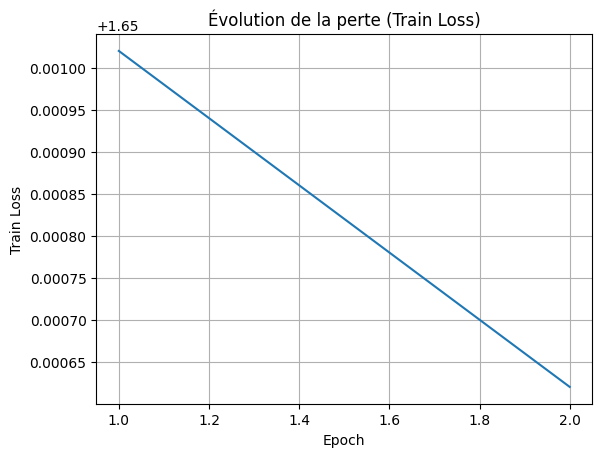

KeyError: 'acc3'

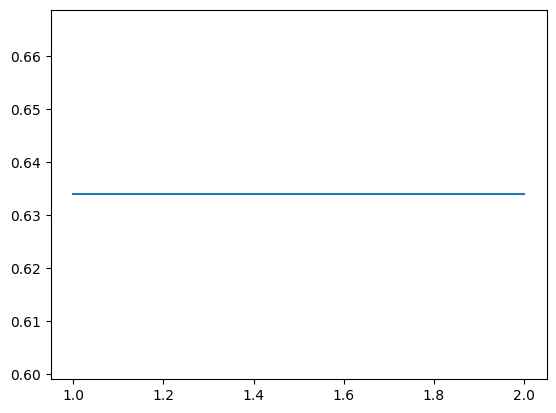

In [39]:
epochs = history["epoch"]

# 1) Train Loss
plt.figure()
plt.plot(epochs, history["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Évolution de la perte (Train Loss)")
plt.grid(True)
plt.show()

# 2) Acc-2 / Acc-3 / Acc-5 / Acc-7 sur la même figure (pratique pour PPT)
plt.figure()
plt.plot(epochs, history["acc2"], label="Acc-2")
plt.plot(epochs, history["acc3"], label="Acc-3")
plt.plot(epochs, history["acc5"], label="Acc-5")
plt.plot(epochs, history["acc7"], label="Acc-7")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Évolution des Accuracy (2/3/5/7 classes)")
plt.legend()
plt.grid(True)
plt.show()

# 3) F1-score
plt.figure()
plt.plot(epochs, history["f1"])
plt.xlabel("Epoch")
plt.ylabel("F1-score (weighted)")
plt.title("Évolution du F1-score binaire (Acc-2)")
plt.grid(True)
plt.show()

# 4) MAE
plt.figure()
plt.plot(epochs, history["mae"])
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Évolution du MAE")
plt.grid(True)
plt.show()

# 5) Corrélation de Pearson
plt.figure()
plt.plot(epochs, history["corr"])
plt.xlabel("Epoch")
plt.ylabel("Corrélation de Pearson")
plt.title("Évolution de la corrélation (Pearson)")
plt.grid(True)
plt.show()


In [ ]:
def train_deva_meld(
    num_epochs: int = 25,
    batch_size: int = 4,
    lr: float = 2e-4,
    freeze_bert_epochs: int = 5,
    save_best_path: str = "best_deva_meld.pt",
):
    """
    Entraîne DEVANet sur MELD (train/dev).

    - num_epochs : nb d'epochs total
    - batch_size : taille des batchs
    - lr : learning rate initial
    - freeze_bert_epochs : nb d'epochs pendant lesquelles on freeze BERT
    - save_best_path : chemin du .pt du meilleur modèle (selon Acc-2 dev)

    Retourne : model, history
    """

    # -------------------- DATA --------------------
    train_ds = MELDVideoDataset(CSV_TRAIN, VIDEO_TRAIN)
    dev_ds   = MELDVideoDataset(CSV_DEV,   VIDEO_DEV)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=meld_collate,
        num_workers=0,    
    )
    dev_loader = DataLoader(
        dev_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=meld_collate,
        num_workers=0,
    )

    # -------------------- MODELE --------------------
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model = DEVANet(tokenizer=tokenizer).to(DEVICE)

    # Freeze BERT au début
    for p in model.text_encoder.bert.parameters():
        p.requires_grad = False
    print(f"BERT FREEZE pour les {freeze_bert_epochs} premiers epochs")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # -------------------- HISTORIQUE --------------------
    history = {
        "epoch": [],
        "train_loss": [],
        "acc2": [],
        "acc3": [],
        "acc5": [],
        "acc7": [],
        "f1": [],
        "mae": [],
        "corr": [],
    }

    best_acc2 = -1.0

    # -------------------- BOUCLE D'ENTRAINEMENT --------------------
    for epoch in range(1, num_epochs + 1):

        #BERT est déjà très bon (pré-entraîné) mais tous le reste random 
        #donc si on laisse BERT apprendre dès le debut avec un LR pas trop petit
        #les gradients venant de la perte vont aussi modifier BERT et partir dans une mauvaise direction
        #on se retrouve avec un embedding des texte dégradés une fusion multimodale instable et les métrique qui explosent
        if epoch == freeze_bert_epochs + 1:
            print(">>> DEFREEZE BERT")
            for p in model.text_encoder.bert.parameters():
                p.requires_grad = True

        # -------- TRAIN --------
        model.train()
        train_losses = []

        for utterances, emotions, audio_paths, sentiments in train_loader:
            sentiments = sentiments.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(utterances, emotions, audio_paths)
            loss = criterion(y_pred, sentiments)
            loss.backward()

            # clipping pour éviter les gros gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = float(np.mean(train_losses))

        # -------- EVAL DEV --------
        model.eval()
        all_true, all_pred = [], []

        with torch.no_grad():
            for utterances, emotions, audio_paths, sentiments in dev_loader:
                sentiments = sentiments.to(DEVICE)
                y_pred = model(utterances, emotions, audio_paths)
                all_true.append(sentiments.cpu().numpy())
                all_pred.append(y_pred.cpu().numpy())

        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
        metrics = evaluate_metrics(y_true, y_pred)

        # -------- SAUVE HISTORIQUE --------
        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["acc2"].append(metrics["Acc-2"])
        history["acc3"].append(metrics["Acc-3"])
        history["acc5"].append(metrics["Acc-5"])
        history["acc7"].append(metrics["Acc-7"])
        history["f1"].append(metrics["F1"])
        history["mae"].append(metrics["MAE"])
        history["corr"].append(metrics["Corr"])

        # -------- LOG --------
        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"  Train Loss : {avg_train_loss:.4f}")
        print(
            f"  Dev -> "
            f"Acc-2={metrics['Acc-2']:.4f} | "
            f"Acc-3={metrics['Acc-3']:.4f} | "
            f"Acc-5={metrics['Acc-5']:.4f} | "
            f"Acc-7={metrics['Acc-7']:.4f} | "
            f"F1={metrics['F1']:.4f} | "
            f"MAE={metrics['MAE']:.4f} | "
            f"Corr={metrics['Corr']:.4f}"
        )

        # -------- SAUVEGARDE MEILLEUR MODELE (Acc-2) --------
        if metrics["Acc-2"] > best_acc2:
            best_acc2 = metrics["Acc-2"]
            if save_best_path is not None:
                torch.save(model.state_dict(), save_best_path)
                print(f"  -> Nouveau meilleur modèle sauvegardé (Acc-2={best_acc2:.4f})")

    print("\nEntraînement terminé.")
    print(f"Meilleure Acc-2 sur dev : {best_acc2:.4f}")

    return model, history

model, history = train_deva_meld(
    num_epochs=25,
    batch_size=8,      
    lr=2e-4,
    freeze_bert_epochs=5,
    save_best_path="best_deva_meldv2.pt",
)


train_sent_emo.csv -> 9989 exemples
dev_sent_emo.csv -> 1109 exemples
BERT FREEZE pour les 5 premiers epochs


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 1/25
  Train Loss : 67.9689
  Dev -> Acc-2=0.6997 | Acc-3=0.2173 | Acc-5=0.2092 | Acc-7=0.2083 | F1=0.6241 | MAE=1.5244 | Corr=0.6942
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.6997)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 2/25
  Train Loss : 9.0436
  Dev -> Acc-2=0.9279 | Acc-3=0.5041 | Acc-5=0.5041 | Acc-7=0.5041 | F1=0.9259 | MAE=1.8690 | Corr=0.8624
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.9279)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 3/25
  Train Loss : 3.5761
  Dev -> Acc-2=0.5509 | Acc-3=0.9071 | Acc-5=0.8530 | Acc-7=0.8142 | F1=0.5132 | MAE=0.2658 | Corr=0.8602


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 4/25
  Train Loss : 1.0581
  Dev -> Acc-2=0.9333 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.9342 | MAE=0.2946 | Corr=0.8641
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.9333)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 5/25
  Train Loss : 0.1731
  Dev -> Acc-2=0.5329 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4876 | MAE=0.1705 | Corr=0.8686
>>> DEFREEZE BERT


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 6/25
  Train Loss : 1.9166
  Dev -> Acc-2=0.3661 | Acc-3=0.4238 | Acc-5=0.4202 | Acc-7=0.1966 | F1=0.1962 | MAE=0.6148 | Corr=0.0561


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 7/25
  Train Loss : 0.5932
  Dev -> Acc-2=0.5392 | Acc-3=0.4238 | Acc-5=0.4229 | Acc-7=0.4229 | F1=0.5325 | MAE=0.5877 | Corr=-0.0691


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 8/25
  Train Loss : 0.8246
  Dev -> Acc-2=0.6339 | Acc-3=0.2101 | Acc-5=0.2101 | Acc-7=0.2101 | F1=0.4919 | MAE=3.1983 | Corr=-0.0607


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 9/25
  Train Loss : 0.5541
  Dev -> Acc-2=0.3661 | Acc-3=0.4238 | Acc-5=0.4238 | Acc-7=0.4238 | F1=0.1962 | MAE=0.5883 | Corr=-0.0501


KeyboardInterrupt: 

# on va verifier que les audios ne sont pas vides : 

Audio len: 44352
Audio mean: -0.00011424243 std: 0.025887407


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3686870154.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(sample_path, sr=16000)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


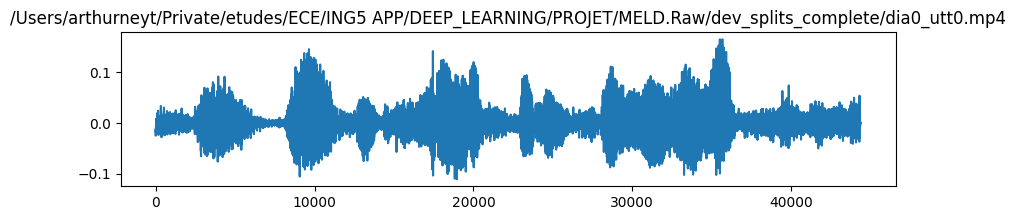

In [37]:
sample_path = dev_ds[0]["audio_path"]
y, sr = librosa.load(sample_path, sr=16000)
print("Audio len:", len(y))
print("Audio mean:", np.mean(y), "std:", np.std(y))
plt.figure(figsize=(10,2))
plt.plot(y)
plt.title(sample_path)
plt.show()


In [ ]:
def train_deva_meld(
    num_epochs: int = 25,
    batch_size: int = 4,
    lr: float = 2e-4,
    freeze_bert_epochs: int = 5,
    save_best_path: str = "best_deva_meld.pt",
):
    """
    Entraîne DEVANet sur MELD (train/dev).

    - num_epochs : nb d'epochs total
    - batch_size : taille des batchs
    - lr : learning rate initial
    - freeze_bert_epochs : nb d'epochs pendant lesquelles on freeze BERT
    - save_best_path : chemin du .pt du meilleur modèle (selon Acc-2 dev)

    Retourne : model, history
    """

    # -------------------- DATA --------------------
    train_ds = MELDVideoDataset(CSV_TRAIN, VIDEO_TRAIN)
    dev_ds   = MELDVideoDataset(CSV_DEV,   VIDEO_DEV)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=meld_collate,
        num_workers=0,    
    )
    dev_loader = DataLoader(
        dev_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=meld_collate,
        num_workers=0,
    )

    # -------------------- MODELE --------------------
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model = DEVANet(tokenizer=tokenizer).to(DEVICE)

    #Freeze BERT au début
    for p in model.text_encoder.bert.parameters():
        p.requires_grad = False
    print(f"BERT FREEZE pour les {freeze_bert_epochs} premiers epochs")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # -------------------- HISTORIQUE --------------------
    history = {
        "epoch": [],
        "train_loss": [],
        "acc2": [],
        "acc3": [],
        "acc5": [],
        "acc7": [],
        "f1": [],
        "mae": [],
        "corr": [],
    }

    best_acc2 = -1.0

    # -------------------- BOUCLE D'ENTRAINEMENT --------------------
    for epoch in range(1, num_epochs + 1):

        if epoch == freeze_bert_epochs + 1:
            print(">>> DEFREEZE BERT with small LR")
            for p in model.text_encoder.bert.parameters():
                p.requires_grad = True

            # NEW OPTIMIZER with tiny lr for BERT
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


        # -------- TRAIN --------
        model.train()
        train_losses = []

        for utterances, emotions, audio_paths, sentiments in train_loader:
            sentiments = sentiments.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(utterances, emotions, audio_paths)
            loss = criterion(y_pred, sentiments)
            loss.backward()

            # clipping pour éviter les gros gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = float(np.mean(train_losses))

        # -------- EVAL DEV --------
        model.eval()
        all_true, all_pred = [], []

        with torch.no_grad():
            for utterances, emotions, audio_paths, sentiments in dev_loader:
                sentiments = sentiments.to(DEVICE)
                y_pred = model(utterances, emotions, audio_paths)
                all_true.append(sentiments.cpu().numpy())
                all_pred.append(y_pred.cpu().numpy())

        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
        metrics = evaluate_metrics(y_true, y_pred)

        # -------- SAUVE HISTORIQUE --------
        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["acc2"].append(metrics["Acc-2"])
        history["acc3"].append(metrics["Acc-3"])
        history["acc5"].append(metrics["Acc-5"])
        history["acc7"].append(metrics["Acc-7"])
        history["f1"].append(metrics["F1"])
        history["mae"].append(metrics["MAE"])
        history["corr"].append(metrics["Corr"])

        # -------- LOG --------
        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"  Train Loss : {avg_train_loss:.4f}")
        print(
            f"  Dev -> "
            f"Acc-2={metrics['Acc-2']:.4f} | "
            f"Acc-3={metrics['Acc-3']:.4f} | "
            f"Acc-5={metrics['Acc-5']:.4f} | "
            f"Acc-7={metrics['Acc-7']:.4f} | "
            f"F1={metrics['F1']:.4f} | "
            f"MAE={metrics['MAE']:.4f} | "
            f"Corr={metrics['Corr']:.4f}"
        )

        # -------- SAUVEGARDE MEILLEUR MODELE (Acc-2) --------
        if metrics["Acc-2"] > best_acc2:
            best_acc2 = metrics["Acc-2"]
            if save_best_path is not None:
                torch.save(model.state_dict(), save_best_path)
                print(f"  -> Nouveau meilleur modèle sauvegardé (Acc-2={best_acc2:.4f})")

    print("\nEntraînement terminé.")
    print(f"Meilleure Acc-2 sur dev : {best_acc2:.4f}")

    return model, history

model, history = train_deva_meld(
    num_epochs=25,
    batch_size=8,
    lr=2e-4,
    freeze_bert_epochs=10,   
)



train_sent_emo.csv -> 9989 exemples
dev_sent_emo.csv -> 1109 exemples
BERT FREEZE pour les 10 premiers epochs


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 1/25
  Train Loss : 87.4140
  Dev -> Acc-2=0.3661 | Acc-3=0.3661 | Acc-5=0.3652 | Acc-7=0.3634 | F1=0.1962 | MAE=2.0126 | Corr=0.0332
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.3661)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 2/25
  Train Loss : 16.0903
  Dev -> Acc-2=0.6240 | Acc-3=0.3291 | Acc-5=0.1371 | Acc-7=0.0812 | F1=0.5065 | MAE=0.7548 | Corr=-0.0402
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.6240)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 3/25
  Train Loss : 5.2119
  Dev -> Acc-2=0.3679 | Acc-3=0.4283 | Acc-5=0.0839 | Acc-7=0.0126 | F1=0.2001 | MAE=0.6408 | Corr=0.0546


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 4/25
  Train Loss : 0.9648
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8025 | Acc-7=0.3535 | F1=0.4585 | MAE=0.4474 | Corr=0.7690


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 5/25
  Train Loss : 0.2392
  Dev -> Acc-2=0.5131 | Acc-3=0.9360 | Acc-5=0.5104 | Acc-7=0.3652 | F1=0.4585 | MAE=0.2749 | Corr=0.8416


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 6/25
  Train Loss : 0.2884
  Dev -> Acc-2=0.5131 | Acc-3=0.9369 | Acc-5=0.8647 | Acc-7=0.4409 | F1=0.4585 | MAE=0.3401 | Corr=0.8656


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 7/25
  Train Loss : 0.1716
  Dev -> Acc-2=0.9369 | Acc-3=0.9351 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.9377 | MAE=0.2605 | Corr=0.8565
  -> Nouveau meilleur modèle sauvegardé (Acc-2=0.9369)


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 8/25
  Train Loss : 0.1883
  Dev -> Acc-2=0.5041 | Acc-3=0.9279 | Acc-5=0.9279 | Acc-7=0.8647 | F1=0.4893 | MAE=0.1908 | Corr=0.8264


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 9/25
  Train Loss : 0.1578
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1631 | Corr=0.8690


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 10/25
  Train Loss : 0.1534
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1493 | Corr=0.8659
>>> DEFREEZE BERT with small LR


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 11/25
  Train Loss : 0.2249
  Dev -> Acc-2=0.5131 | Acc-3=0.9369 | Acc-5=0.9369 | Acc-7=0.9369 | F1=0.4585 | MAE=0.1587 | Corr=0.7798


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 12/25
  Train Loss : 0.2251
  Dev -> Acc-2=0.5041 | Acc-3=0.9279 | Acc-5=0.9279 | Acc-7=0.9279 | F1=0.4893 | MAE=0.1779 | Corr=0.7699


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 13/25
  Train Loss : 0.1562
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1669 | Corr=0.8689


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 14/25
  Train Loss : 0.1279
  Dev -> Acc-2=0.5041 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4893 | MAE=0.1551 | Corr=0.8641


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 15/25
  Train Loss : 0.1270
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1635 | Corr=0.8690


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 16/25
  Train Loss : 0.1208
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1595 | Corr=0.8689


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 17/25
  Train Loss : 0.1208
  Dev -> Acc-2=0.9279 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.9259 | MAE=0.1639 | Corr=0.8682


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 18/25
  Train Loss : 0.1217
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1534 | Corr=0.8693


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 19/25
  Train Loss : 0.1220
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1538 | Corr=0.8690


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 20/25
  Train Loss : 0.1207
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1624 | Corr=0.8690


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 21/25
  Train Loss : 0.1251
  Dev -> Acc-2=0.5131 | Acc-3=0.9369 | Acc-5=0.9369 | Acc-7=0.9369 | F1=0.4585 | MAE=0.1699 | Corr=0.7801


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 22/25
  Train Loss : 0.1275
  Dev -> Acc-2=0.9369 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.9377 | MAE=0.1624 | Corr=0.8691


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 23/25
  Train Loss : 0.1207
  Dev -> Acc-2=0.5131 | Acc-3=0.8647 | Acc-5=0.8647 | Acc-7=0.8647 | F1=0.4585 | MAE=0.1591 | Corr=0.8689


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 24/25
  Train Loss : 0.2814
  Dev -> Acc-2=0.3661 | Acc-3=0.4238 | Acc-5=0.4238 | Acc-7=0.4238 | F1=0.1962 | MAE=0.5803 | Corr=-0.1302


/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/3182778670.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr)
/Users/arthurneyt/Private/etudes/ECE/ING5 APP/DEEP_LEARNING/PROJET/.venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/d5/m7mxnsns48l285k89c9pxc4m0000gn/T/ipykernel_75243/1821340542.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000)



Epoch 25/25
  Train Loss : 0.5263
  Dev -> Acc-2=0.3661 | Acc-3=0.4238 | Acc-5=0.4238 | Acc-7=0.4238 | F1=0.1962 | MAE=0.5891 | Corr=-0.0677

Entraînement terminé.
Meilleure Acc-2 sur dev : 0.9369


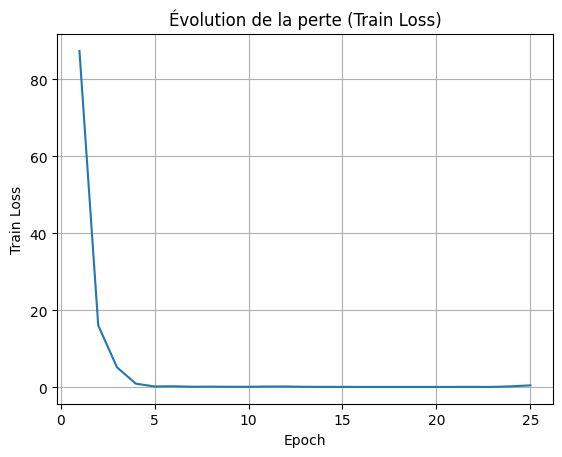

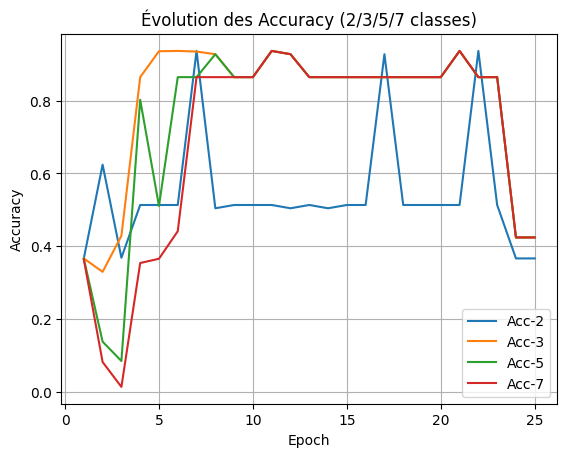

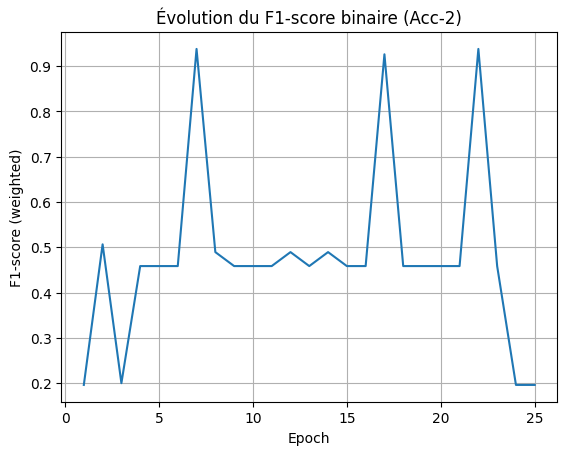

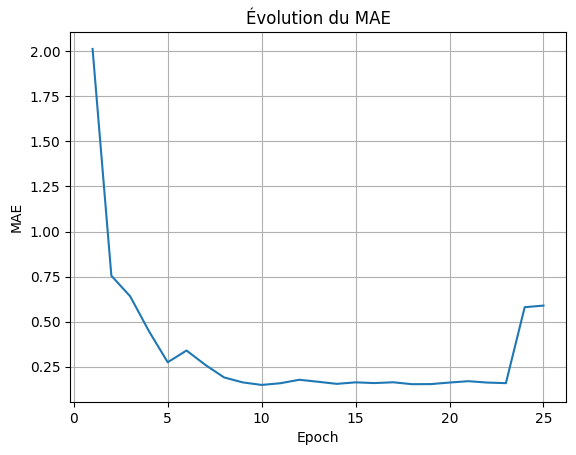

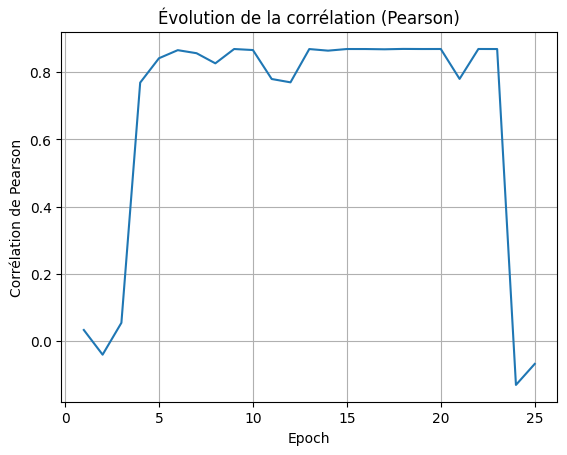

In [42]:
epochs = history["epoch"]

# 1) Train Loss
plt.figure()
plt.plot(epochs, history["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Évolution de la perte (Train Loss)")
plt.grid(True)
plt.show()

# 2) Acc-2 / Acc-3 / Acc-5 / Acc-7 sur la même figure (pratique pour PPT)
plt.figure()
plt.plot(epochs, history["acc2"], label="Acc-2")
plt.plot(epochs, history["acc3"], label="Acc-3")
plt.plot(epochs, history["acc5"], label="Acc-5")
plt.plot(epochs, history["acc7"], label="Acc-7")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Évolution des Accuracy (2/3/5/7 classes)")
plt.legend()
plt.grid(True)
plt.show()

# 3) F1-score
plt.figure()
plt.plot(epochs, history["f1"])
plt.xlabel("Epoch")
plt.ylabel("F1-score (weighted)")
plt.title("Évolution du F1-score binaire (Acc-2)")
plt.grid(True)
plt.show()

# 4) MAE
plt.figure()
plt.plot(epochs, history["mae"])
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Évolution du MAE")
plt.grid(True)
plt.show()

# 5) Corrélation de Pearson
plt.figure()
plt.plot(epochs, history["corr"])
plt.xlabel("Epoch")
plt.ylabel("Corrélation de Pearson")
plt.title("Évolution de la corrélation (Pearson)")
plt.grid(True)
plt.show()


# On va tester en chargent le meilleur modèle 

In [ ]:
import os
from pathlib import Path

def load_best_model(checkpoint_path: str) -> DEVANet:
    """
    Recharge DEVANet avec les mêmes paramètres que pendant l'entraînement
    et charge les poids sauvegardés.
    """
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model = DEVANet(tokenizer=tokenizer).to(DEVICE)
    state_dict = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    return model


def evaluate_on_test_skip_errors(
    checkpoint_path: str = "best_deva_meld.pt",
    max_examples_to_show: int = 10,
):
    # -------- Chargement du modèle --------
    model = load_best_model(checkpoint_path)
    print(f"✅ Modèle chargé depuis : {checkpoint_path}")

    # -------- Chargement du dataset TEST --------
    test_ds = MELDVideoDataset(CSV_TEST, VIDEO_TEST)
    print("Taille totale du test set :", len(test_ds))

    y_true_list = []
    y_pred_list = []
    saved_examples = []

    # -------- Parcours des exemples du test --------
    for idx in range(len(test_ds)):
        utterance, emotion, audio_path, sentiment = test_ds[idx]

        try:
            with torch.no_grad():
                # Le modèle attend des listes → on encapsule dans des listes
                y_pred_tensor = model([utterance], [emotion], [audio_path])

            y_pred = float(y_pred_tensor.cpu().item())
            y_true = float(sentiment)

            y_true_list.append(y_true)
            y_pred_list.append(y_pred)

            # On garde l'exemple pour affichage
            fname = os.path.basename(audio_path) if audio_path else ""
            saved_examples.append((fname, utterance, emotion, y_true, y_pred))

        except Exception as e:
            # Si un problème audio / codec / autre se produit → on skip
            fname = os.path.basename(audio_path) if audio_path else f"idx_{idx}"
            print(f"⛔️ Exemple {fname} ignoré (erreur) :", e)
            continue

    # Aucun exemple
    if len(y_true_list) == 0:
        print("⚠️ Aucun exemple valide n'a pu être évalué (tous ont levé une erreur).")
        return

    # Conversion numpy
    y_true = np.array(y_true_list)
    y_pred = np.array(y_pred_list)

    # -------- Métriques --------
    metrics = evaluate_metrics(y_true, y_pred)

    print("\n📊 MÉTRIQUES sur le test (exemples sans erreur)")
    print("-----------------------------------------------")
    print(f"Exemples utilisés : {len(y_true_list)} / {len(test_ds)}")
    print(f"Acc-2 = {metrics['Acc-2']:.4f}")
    print(f"Acc-3 = {metrics['Acc-3']:.4f}")
    print(f"Acc-5 = {metrics['Acc-5']:.4f}")
    print(f"Acc-7 = {metrics['Acc-7']:.4f}")
    print(f"F1    = {metrics['F1']:.4f}")
    print(f"MAE   = {metrics['MAE']:.4f}")
    print(f"Corr  = {metrics['Corr']:.4f}")

    # -------- Exemples qualitatifs --------
    print("\n🔍 Exemples (prédiction vs vérité)")
    print("---------------------------------")
    n_show = min(max_examples_to_show, len(saved_examples))

    for i in range(n_show):
        fname, utt, emo, y_t, y_p = saved_examples[i]
        print(f"\nExemple {i+1}/{n_show} : {fname}")
        print(f"  Utterance : {utt}")
        print(f"  Emotion   : {emo}")
        print(f"  Vrai y    : {y_t:.3f}")
        print(f"  Prédit y  : {y_p:.3f}")


# -------------------------------------------------------------
# Appel
# -------------------------------------------------------------
evaluate_on_test_skip_errors(
    checkpoint_path="best_deva_meld.pt",
    max_examples_to_show=8,
)

✅ Modèle chargé depuis : best_deva_meld.pt
test_sent_emo.csv -> 2610 exemples
Taille totale du test set : 2610
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentiment ignoré (erreur) : could not convert string to float: 'audio_path'
⛔️ Exemple sentimen